In [4]:
from pathlib import Path
import pandas as pd
import json
import re 
import os 

## Downloading cohort from Discovery and extracting thickness & parameters
<small>

This notebooks presents step-by-step instructions to download the AOSLO healthy cohort from Discovery to extract data such as thicknesses and other parameters, to populate the database in [`P:\AOSLO\_automation\_PROCESSED\Photoreceptors\Healthy\_Results`](</P:/AOSLO/_automation/_PROCESSED/Photoreceptors/Healthy/_Results/>). 

### Downloading & cleaning the cohort

<small>
In order to download the cohort using CohortExtractor, use the following command (and ask the person in charge of CohortBuilder to do it for you):

```bash
$ cb-dev download -i fhv_jugo -p AOSLO -w AOSLO\ healthy --configs download_aoslo_healthy --cohorts_dir /path/to/output/directory
```
where `/path/to/output/directory` is the directory where the cohort will be downloaded, typically looks like `/mnt/faa_studies/Studies/AOSLO/data/cohorts`.

Before browsing it and actually exploit it for the analysis, clean the downloaded cohort of the unnecessary/invalid studies and datasets by running the following cell and reading its output (in particular, look out for the warnings (/!\\) and follows the instructions to fix them). Go to the next cell once the output of the following cell contains no warnings.
</small>

In [5]:
import numpy as np
from typing import List

sheet = pd.ExcelFile(r'V:\Studies\AOSLO\data\cohorts\AOSLO healthy\DATA_HC+DM.xlsx').parse('Healthy', header=0, nrows=45, index_col=0)
subject_to_laterality = sheet['Laterality'].apply(lambda s: 'R' if s=='OD' else 'L').to_dict()

lut_subject_to_paths = {}

base_path = Path(r'V:\Studies\AOSLO\data\cohorts\AOSLO healthy\AOSLO healthy')
studies_to_delete_all = []
datasets_to_delete_all = []
for subject_path in base_path.glob('AOHC_* *'):
    if not subject_path.is_dir():
        continue
    try:
        subject_nb = int(subject_path.name.split(' ')[0].lstrip('AOHC_'))
    except ValueError:
        print(f'Could not parse subject number from {subject_path.name}')
        continue
    print(f'\n\n-------------- Subject {subject_nb:03d} ----------------------\n')
    cube_path = None
    linex_path = None
    liney_path = None
    found_valid_study = False
    studies_to_delete = []
    datasets_to_delete = []
    for study_path in subject_path.glob('*'):
        if not study_path.is_dir():
            continue

        datasets_to_delete_ = []
        cubes = []
        lines_X = []
        lines_Y = []
        nb_datasets = 0
        for p in study_path.glob('*/info.json'):
            nb_datasets += 1
            with open(p) as f:
                infos = json.load(f)

            dataset_path = p.parent

            if infos['laterality'] != subject_to_laterality[subject_nb]:
                datasets_to_delete_.append(dataset_path)
                continue

            if 'OCT_CUBE' in infos['layerVariants']:
                cubes.append(dataset_path)
            elif 'OCT_LINE' in infos['layerVariants']:
                match int(infos['angles'][0]):
                    case 0:
                        lines_X.append(dataset_path)
                    case 90:
                        lines_Y.append(dataset_path)
                    case _:
                        print(f'Angle not handled for {dataset_path}: {infos['angles'][0]}°')
                        datasets_to_delete_.append(dataset_path)
            else:
                datasets_to_delete_.append(dataset_path)
                continue
            
        if any(len(l) == 0 for l in [cubes, lines_X, lines_Y]):
            studies_to_delete.append(study_path)
            continue
        if found_valid_study:
            print(fr'/!\ Multiple STUDIES for subject {subject_nb} seem to be valid:')
            print('Please manually select one to keep by deleting the others (check which is the best-quality one on Discovery)\nAfter manual cleaning, please rerun this cell.\n')
        
        def get_best_dataset(dataset_paths: List[Path]) -> Path:
            shapes = [
                (dataset_path, json.load(open(info_path))['shape'])
                for dataset_path in dataset_paths
                if (info_path := dataset_path / 'oct/volume/info.json').exists()
            ]
            max_y_resolution = max(s[1][0] for s in shapes)
            max_shapes = [s for s in shapes if s[1][0] == max_y_resolution]
            max_tot_resolution = max(np.prod(s[1]) for s in max_shapes)
            datasets = [s[0] for s in max_shapes if np.prod(s[1]) == max_tot_resolution]
            if len(datasets) > 1:
                print(r'/!\ Multiple DATASETS have the same maximum shape:')
                for dataset in datasets:
                    print('  -', '/'.join(dataset.parts[-4:]))
                print('Please manually select one to keep by deleting the others (check which is the best-quality one on Discovery)\nAfter manual cleaning, please rerun this cell.\n')
            return datasets[0]
        cube_path = get_best_dataset(cubes)
        linex_path = get_best_dataset(lines_X)
        liney_path = get_best_dataset(lines_Y)
        datasets_to_delete_.extend(set(cubes + lines_X + lines_Y) - {cube_path, linex_path, liney_path})
        assert nb_datasets == len(datasets_to_delete_) + 3, f'Unexpected number of datasets in study {study_path}'
        datasets_to_delete = datasets_to_delete_
        found_valid_study = True

    assert found_valid_study, f'No valid study found for subject {subject_nb}'
    lut_subject_to_paths[subject_nb] = {
        'cube': str(cube_path),
        'line_X': str(linex_path),
        'line_Y': str(liney_path),
    }
    print('Keeping:', json.dumps(lut_subject_to_paths[subject_nb], indent=4))
    
    if len(datasets_to_delete) > 0:
        datasets_to_delete_all.extend(datasets_to_delete)
        print('Datasets that will be deleted:')
        for dd in datasets_to_delete:
            print('  -', str(dd))
    if len(studies_to_delete) > 0:
        studies_to_delete_all.extend(studies_to_delete)
        print('Studies that will be deleted:')
        for sd in studies_to_delete:
            print('  -', str(sd))



-------------- Subject 010 ----------------------

Keeping: {
    "cube": "V:\\Studies\\AOSLO\\data\\cohorts\\AOSLO healthy\\AOSLO healthy\\AOHC_10 7253fb8e\\2021-12-17 e5c15549\\a8a18ab8",
    "line_X": "V:\\Studies\\AOSLO\\data\\cohorts\\AOSLO healthy\\AOSLO healthy\\AOHC_10 7253fb8e\\2021-12-17 e5c15549\\d8c6c506",
    "line_Y": "V:\\Studies\\AOSLO\\data\\cohorts\\AOSLO healthy\\AOSLO healthy\\AOHC_10 7253fb8e\\2021-12-17 e5c15549\\fad6b8a2"
}


-------------- Subject 100 ----------------------

Keeping: {
    "cube": "V:\\Studies\\AOSLO\\data\\cohorts\\AOSLO healthy\\AOSLO healthy\\AOHC_100 871650c9\\2022-03-28 06dd9aaf\\e06d9e52",
    "line_X": "V:\\Studies\\AOSLO\\data\\cohorts\\AOSLO healthy\\AOSLO healthy\\AOHC_100 871650c9\\2022-03-28 06dd9aaf\\273c57ae",
    "line_Y": "V:\\Studies\\AOSLO\\data\\cohorts\\AOSLO healthy\\AOSLO healthy\\AOHC_100 871650c9\\2022-03-28 06dd9aaf\\02b81755"
}


-------------- Subject 101 ----------------------

Keeping: {
    "cube": "V:\\Studies\\A

KeyboardInterrupt: 

<small>

Once above cell's output contains no /!\ warnings, you can save the `subject -> oct data paths` look-up table to a `json` file by running the following cell. Then, you can delete all the unnecessary datasets and studies determined in the previous cell using the next cell.

In [ ]:
json.dump(lut_subject_to_paths, open(r'V:\Studies\AOSLO\data\cohorts\AOSLO healthy\lut_subject_to_oct_data_paths.json', 'w'), indent=4)

In [ ]:
import shutil
for path in studies_to_delete_all + datasets_to_delete_all:
    print(f'Deleting {path}')
    shutil.rmtree(path)

###
<small>

Now the cohort (saved in [`V:\Studies\AOSLO\data\cohorts\AOSLO healthy`](<V:\Studies\AOSLO\data\cohorts\AOSLO healthy>)) is clean, we can for each subject compute and save the interesting features; for now, those are:
- choroidal vascularity index (CVI - from Discovery)
- retinal layers thicknesses (RNFL, GCL+IPL, INL+OPL, ONL, PR+RPE, Choroid - all from Discovery)
- Outer Segment of the photoreceptors layer thickness (homemade segmentation)
- foveal shape parameters (such as pit depth, width, max slope, flatness, etc.)

The first two comes for free using CohortExtractor's `browse` function, based on the segmentation of Discovery software. The latter two are homemade and will be computed here. All these features are saved in `json`/`csv` files in the `Subject*/Session*/layer_new` directory of each subject of the cohort.

In [6]:
import sys
src_path = Path.cwd().parent # specify here the path to the src folder (root of the project)
sys.path.append(src_path.as_posix())
from src.configs.parser import Parser
Parser.initialize()

layer_dir_name = Parser.get_layer_thickness_dir()
output_dir = Path(r'P:\AOSLO\_automation\_PROCESSED\Photoreceptors\Healthy\_Results')
for sess_path in output_dir.glob('Subject*/Session*'):
	# just making sure that the layer directory exists
	(sess_path / layer_dir_name).mkdir(exist_ok=True, parents=True)

### Extracting foveal shape parameters

Recall model of foveal shape -- extraction is handled by [src/cell/layer/foveal_shape_extraction.py](cell/layer/foveal_shape_extraction.py).

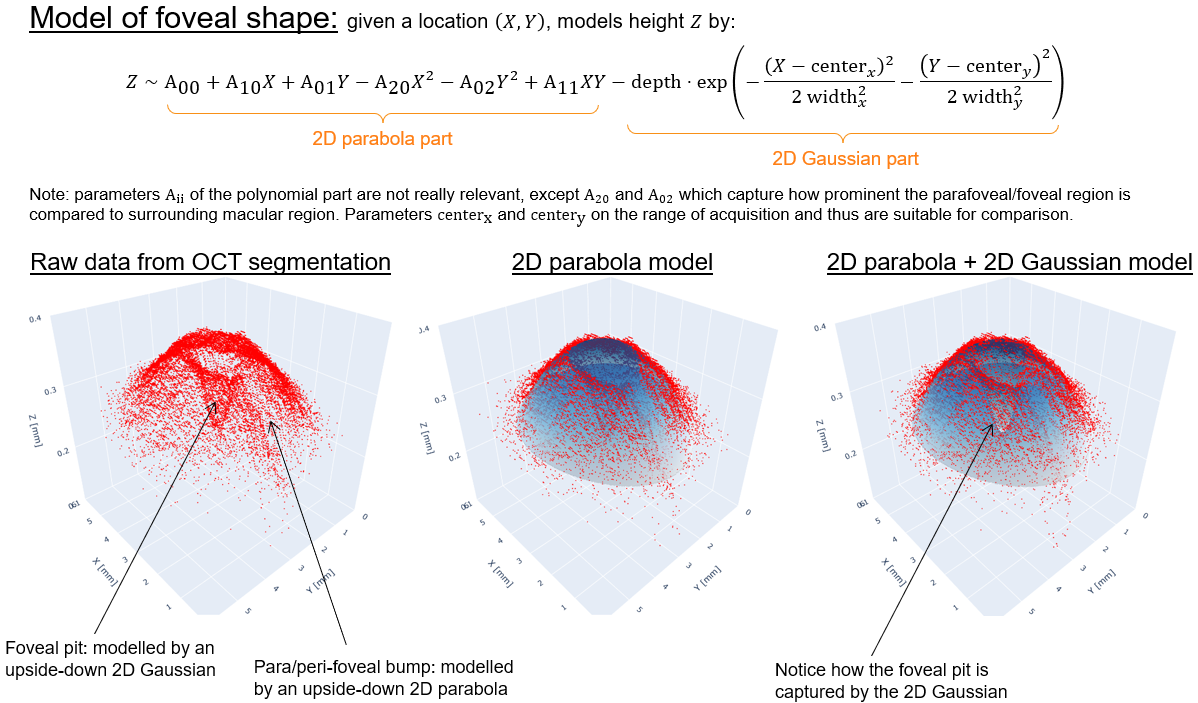

Aside from these 11 model parameters, we also extract the following 3 characteristics:

- $\texttt{max\_slope}$ is the maximum of the gradient of above formula over an the interior of an ellipse centered at $(\texttt{center}_x, \texttt{center}_y)$ with axes proportional to $\texttt{width}_x$ and $\texttt{width}_y$ so that the considered region covers ~only the fovea.

- $\texttt{flatness}$ is the inverse of the 0.4 quantile of the gradient of the foveal shape over the interior of a similar ellipse, but smaller in order for the region to cover ~only the bottom of the foveal pit. The bigger the $\texttt{flatness}$ value, the flatter the bottom of the foveal pit, and vice versa.

- $\texttt{volume}$ is an approximation of the total volume (in $\mathrm{mm}^3$) for the foveal pit, defined as $2\pi\cdot\texttt{width}_x\cdot\texttt{width}_y\cdot\texttt{depth}$ (formula comes from the Gaussian 2D integral).

In [ ]:
#check type of lut subject keys, they should be int
if not all(isinstance(k, int) for k in lut_subject_to_paths.keys()):
    raise ValueError('Keys of the LUT should be integers')

print (lut_subject_to_paths.keys())

In [ ]:


from src.cell.layer.foveal_shape_extraction import extract_foveal_shape_params, get_oct_shape_3d

for sess_path in output_dir.glob('Subject*/Session*'):
    subject_nb = re.search(r'\d+', sess_path.parent.name).group()
    print(f'\n\n-------------- Subject {subject_nb} ----------------------\n')
    #check type of subject_nb, it should be int
    if not isinstance(subject_nb, int):
        Warning('Subject number should be an integer, had to convert it to int')
        subject_nb = int(subject_nb)
    
    print (f'Processing {sess_path}')
    # print (f"lut_subject_to_paths:{lut_subject_to_paths[subject_nb]}")
    if subject_nb not in lut_subject_to_paths:
        print(f'No OCT data found for subject {subject_nb}')
        continue
    dataset_path = Path(lut_subject_to_paths[subject_nb]['cube'])
    raw_oct_shape_3d, _range = get_oct_shape_3d(dataset_path, f'Subject{subject_nb}')
    df_oct = extract_foveal_shape_params(raw_oct_shape_3d, _range, data_to_csv=sess_path / layer_dir_name / 'fovea_3d.csv')
    if df_oct is None:
        print(f'Encountered issue when extracting foveal parameters for Subject{subject_nb}')
        continue
    df_oct.to_csv(sess_path / layer_dir_name / 'fovea_3d_fitted_params.csv', index=True, header=True, float_format='%.8g', na_rep='', sep=';')
    print(f'Done for Subject{subject_nb}')

### Extracting Outer Segment layer thicknesses

<small>

Segmenting the OS layer of OCT cubes and extracting its thickness, which is done in the next cell here, requires to have filled the look-up table  [`V:\Studies\AOSLO\data\cohorts\AOSLO healthy\lut_subject_to_white_dot_bscan.json`](</V:/Studies/AOSLO/data/cohorts/AOSLO healthy/lut_subject_to_white_dot_bscan.json>) for all the subjects of the cohort. 

It maps each subject to the number of the central B-scan of the OCT cube (see [`V:\Studies\AOSLO\data\cohorts\AOSLO healthy\lut_subject_to_oct_data_paths.json`](</V:\Studies\AOSLO\data\cohorts\AOSLO healthy\lut_subject_to_oct_data_paths.json>) to see which cube to look at for your subject), i.e. the one that contains the bright white dot in the fovea pit. E.g., if the white dot is in the B-scan 48/97, please report 48 in the look-up table for this subject.

In [ ]:
from src.cell.layer.os_layer_extraction import get_OS_thicknesses

In [ ]:
for sess_path in output_dir.glob('Subject*/Session*'):
    subject_nb = re.search(r'\d+', sess_path.parent.name).group()
    # subject_nb = int(107)
    if not isinstance(subject_nb, int):
        print(f'Subject number {subject_nb} should be an integer, had to convert it to int')
        subject_nb = int(subject_nb)

    if subject_nb not in lut_subject_to_paths:
        print(f'No OCT data found for subject {subject_nb}')
        continue
    dataset_path = Path(lut_subject_to_paths[subject_nb]['cube'])
    try:
        os_thicknesses = get_OS_thicknesses(int(subject_nb), dataset_path, debug=False)
        #print(os_thicknesses["2745ff3d"]["0051"])


    except Exception as e:
        print(f'Encountered issue when extracting OS layer thicknesses for Subject{subject_nb}')
        print(e)
        raise ValueError(e)
        # continue
    with open(sess_path / layer_dir_name / 'layer_os.json', 'w') as f:
        json.dump(os_thicknesses, f, indent=4)
    print(f'Done for Subject{subject_nb}')

### Extracting other retinal layer thicknesses & CVI

<small>

In order to produce the `browsed.json` file which contains the thicknesses & CVI data from the cleaned cohort, use the `browse` method from CohortBuilder's `Cohort` class. For that, open a terminal and run the following commands:

```bash
$ ssh cohortbuilder@sfhvcohortbuilder01
$ cd /cohortbuilder/cohortbuilder-dev/
$ conda activate cb
$ python
```
Then, in the python console:
```python
>>> from src.cohortextractor.tools.cohort import Cohort
>>> import asyncio
>>> asyncio.run(Cohort('path/to/downloaded/cohort').browse(file='path/to/browsed.json', tvs=True, cvi_cube=True, fovea=True))
```
where `'path/to/downloaded/cohort'` typically looks like `'/mnt/faa_studies/Studies/AOSLO/data/cohorts/AOSLO healthy/AOSLO healthy'`, and `'path/to/browsed.json'` looks like `'/mnt/faa_studies/Studies/AOSLO/data/cohorts/AOSLO healthy/browsed.json'`.
</small>

In [ ]:
with open(r'V:\Studies\AOSLO\data\cohorts\AOSLO healthy\browsed.json') as f:
    browsed = json.load(f)

# for each patient, there should be one study of one OCT cube datasets. The
# layer thicknesses and CVIs are saved in respective JSON files, under the
# directory `SubjectXX/SessionXXX/layer_new`

for patient, studies in browsed.items():
    try:

        subject_nb = int(patient.split(' ')[0].lstrip('AOHC_'))
        print("DEBUG: Processing patient", subject_nb)

    except ValueError:
        print(f'Could not parse {patient}')
        continue
    
    assert len(studies) == 1, f'Unexpected number of studies for patient {patient}; should be 1, got {studies.keys()}'
    study, datasets = next(iter(studies.items()))
    
    datasets = [d for d in datasets if 'OCT_CUBE' in d['info']['layerVariants']]
    assert len(datasets) == 1, f'Unexpected number of OCT cube datasets for patient {patient} in study {study}; should be 1, got {[Path(d['folder']).name for d in datasets]}'
    dataset = next(iter(datasets))

    # extract spacing informations of the OCTs
    spacing = dataset['oct']['info']['spacing']
    spacing = {'x': spacing[3], 'y': spacing[0], 'z': spacing[2]}
    
    # recover the layer thicknesses
    assert dataset['tvss'] is not None
    thicknesses = {study: dataset['tvss'], 'spacing': spacing}
    
    # recover the CVIs
    assert dataset['cvis'] is not None
    cvis = {study: dataset['cvis'], 'spacing': spacing}

    # save them in the corresponding directory
    for sess_path in output_dir.glob(f'Subject{subject_nb}/Session*'):
        with open(sess_path / layer_dir_name / 'layer_thickness.json', 'w') as f:
            json.dump(thicknesses, f, indent=4)
        with open(sess_path / layer_dir_name / 'layer_cvis.json', 'w') as f:
            json.dump(cvis, f, indent=4)
    print(f'Done for Subject{subject_nb}: {patient} / {study} / {Path(dataset["folder"]).name}')

DEBUG: Processing patient 10
DEBUG: Processing patient 100
DEBUG: Processing patient 101
DEBUG: Processing patient 104
DEBUG: Processing patient 105
DEBUG: Processing patient 107
DEBUG: Processing patient 108
DEBUG: Processing patient 11
DEBUG: Processing patient 12
DEBUG: Processing patient 13
DEBUG: Processing patient 15
DEBUG: Processing patient 16
DEBUG: Processing patient 18
DEBUG: Processing patient 19
DEBUG: Processing patient 20
DEBUG: Processing patient 24
DEBUG: Processing patient 25
DEBUG: Processing patient 26
DEBUG: Processing patient 27
DEBUG: Processing patient 28
DEBUG: Processing patient 29
DEBUG: Processing patient 30
DEBUG: Processing patient 33
DEBUG: Processing patient 34
DEBUG: Processing patient 35
DEBUG: Processing patient 36
DEBUG: Processing patient 37
DEBUG: Processing patient 38
DEBUG: Processing patient 39
DEBUG: Processing patient 40
DEBUG: Processing patient 41
DEBUG: Processing patient 42
DEBUG: Processing patient 46
DEBUG: Processing patient 47
DEBUG: P

KeyboardInterrupt: 